# Kinoshita Curve River Transect Example

This notebook showcases an example of the _WigglyRivers_ tool by creating, extracting and interpreting the meandering features of Kinoshita-type river transects. The Kinoshita curve can be estimated using the the function `RiverFunctions.kinoshita_curve_zolezzi(...)`. This equation uses the equations of the Kinoshita curve provided by Zolezzi and Güneralp (2016). The Kinoshita curve uses the following equations to calculate the direction angle ($\theta$) and the curvature ($C$).

$$\theta = \theta_0 \cos(\kappa s) + \theta_{s} \sin(3\kappa s) + \theta_f \cos(3\kappa s)$$

$$C=\kappa[\theta_0 \sin(\kappa s) - 3\theta_s\cos(3\kappa s) + 3\theta_f\sin(3\kappa s)]$$

where $\kappa=2\pi/\lambda$, $\lambda$ is the wavelength of the meander, $\theta_0$ is the amplitude of the direction angle oscillation, and $\theta_s$ and $\theta_f$ are the skewness and fatness coefficients, respectivelly.

## Workflow

To start with this workflow we first import the packages necessary to run the code.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [3]:
# Importing Packages
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display, HTML
from IPython.display import display
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean
from scipy import interpolate
import statsmodels.api as sm

# Importing WigglyRivers Packages
from WigglyRivers import RiverDatasets, RiverTransect
from WigglyRivers import RiverFunctions as RF
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers import WaveletTreeFunctions as WTFunc
from WigglyRivers import Logger
from WigglyRivers import waveletFunctions as cwt_func
from WigglyRivers import graphs

# Set seed for numpy
np.random.seed(0)

In [4]:
# Start Logger to keep track of the code, not needed to run the codes
logger = Logger(console=True)

2023-11-27 14:53:04,921[INFO] set_logger: Starting log


### Creation of the Kinoshita-type River Transect

The following code block shows how to create a river transect using a Kinoshita curve. It also presents the metrics that will be used to evaluate the rivers and the meanders (Figure XXX in the manuscript).

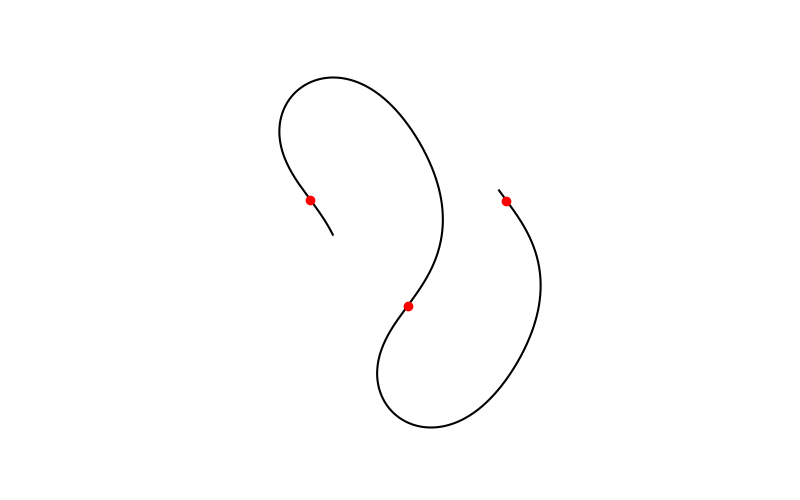

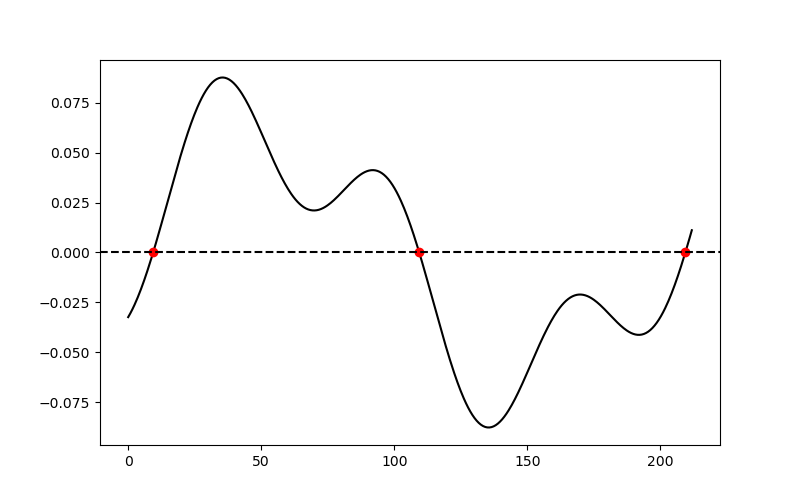

In [5]:
# ------------------------------ 
# Create Kinoshita Curve 
# ------------------------------
theta_0 = 115*np.pi/180  # radians
# Create 2 Full meanders (4 half-meanders)
x_k, y_k, data = RF.kinoshita_curve_zolezzi(
    theta_0=theta_0, lambda_value=200, theta_s=0.344, theta_f=0.031, n=2)
w = np.ones_like(x_k)*2
# Extract variables 
s = data['s']
c = data['c']
# Cut to 2 meanders
cut = 1000//2 + 30
x_k = x_k[:cut]
y_k = y_k[:cut]
s = s[:cut]
c = c[:cut]
# Extract inflection points
s_inf, c_inf, ind_l, _ = RF.get_inflection_points(s, c)
x_inf = x_k[ind_l]
y_inf = y_k[ind_l]

# Find maxima in curvature


# Plot Kinoshita Curve
plt.close('all')
plt.figure(figsize=(8, 5))
plt.plot(x_k, y_k, '-k')
plt.plot(x_inf, y_inf, 'or')
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

# Plot curvature
plt.figure(figsize=(8, 5))
plt.plot(s, c, '-k')
plt.plot(s_inf, c_inf, 'or')
plt.axhline(0, color='k', linestyle='--')
plt.show()

### River Transect Multiscale Characterization

In the code blocks we will be using the spectral tools within _WigglyRivers_ to explore the multiscale nature of the river transects that can be created with the Kinoshita curves. We approach this characterization in two parts. In the first part, we explored three Kinoshita-type river transects with 40 meander bends that have the same wavelength ($\lambda=100$ m), skewness ($\theta_s=0.344$), and fatness ($\theta_f=0.031$) but vary in the amplitude of the direction angle oscillation as $\theta_0=[37.24, 60, 120]$. 


In [6]:
# -----------------------------------------------
# Functions for Kinoshita Curve exploration
# -----------------------------------------------
def explore_kinoshita_values(theta_0, lambda_value, theta_s, theta_f, n,
                             plot_flag=False):
    x_k, y_k, data = RF.kinoshita_curve_zolezzi(
        theta_0=theta_0, lambda_value=lambda_value, theta_s=theta_s,
        theta_f=theta_f, n=n)
    w_m = np.ones_like(x_k)
    # Create River Object
    rivers_k = RiverDatasets(logger=logger)
    rivers_k.add_river('0', x_k, y_k, w_m=w_m, resample_flag=True,
                       kwargs_resample={}, scale_by_width=False)
    # Calculate curvature
    rivers_k['0'].calculate_curvature()
    # Calculate CWT
    rivers_k['0'].get_cwt_curvature(mother='MORLET')
    rivers_k['0'].get_cwt_angle(mother='MORLET')
    results = {
        'rivers': rivers_k,
    }
    return results


2023-11-27 15:18:20,428[INFO] info: Start Logger in RiverDatasets
2023-11-27 15:18:20,439[INFO] info: Resample calculated with `River.calculate_spline()`
2023-11-27 15:18:20,644[INFO] info: Start Logger in RiverDatasets
2023-11-27 15:18:20,649[INFO] info: Resample calculated with `River.calculate_spline()`
2023-11-27 15:18:20,854[INFO] info: Start Logger in RiverDatasets
2023-11-27 15:18:20,859[INFO] info: Resample calculated with `River.calculate_spline()`


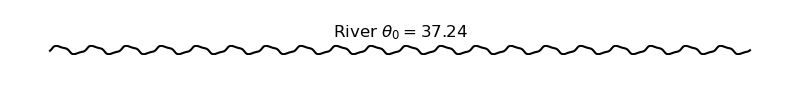

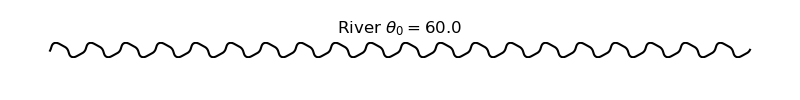

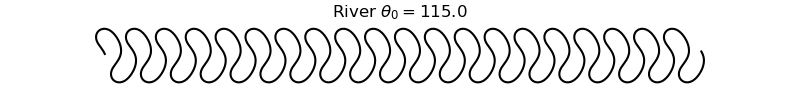

In [7]:
# -----------------------------------------------
# Creation of the Kinoshita-type River transects
# -----------------------------------------------
theta_0 = np.array([37.24, 60, 115])  # Degrees
theta_s = np.array([0.344, 0.344, 0.344])
theta_f = 0.031
lambda_value = 100
n = 20
variables = ['rivers']
results_theta = {i: [] for i in variables}
# Explore values
for i in range(len(theta_0)):
    result = explore_kinoshita_values(
        theta_0[i]*np.pi/180, lambda_value, theta_s[i], theta_f, n)
    for var in variables:
        results_theta[var].append(result[var])

# --------------
# Plot Rivers
# --------------
utl.cr_folder('kinoshita_results/')
river_ids = np.arange(len(theta_0))
for river_id in river_ids:
    x_ch = results_theta['rivers'][river_id]['0'].x
    y_ch = results_theta['rivers'][river_id]['0'].y
    plt.figure(figsize=(8, 1))
    plt.plot(x_ch, y_ch, '-k')
    # plt.plot(x_ch, y_ch, 'ob')
    plt.title(f'River $\\theta_0={theta_0[river_id]}$')
    plt.gca().set_aspect('equal', adjustable='box')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Remove axis lines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'kinoshita_results/river_{river_id}.png', dpi=300)


#### Spectral Analysis

Within the function `explore_kinoshita_values()` we calculate the curvature ($C$) and the direction angle ($\theta$) and apply a Continous Wavelet Transform (CWT) to these variables to gain insight into the spectral properties of these river transects. Finally, we calculate the global wavelet spectrum (GWS) and the scale-averaged wavelet power (SAWP) over the significant scales of the CWT. On this first analysis we are interested in looking into the periodicity of the meander bends, thus we decided to use the Morlet mother wavelet, similarly to what done by Zolezzi and Güneralp (2016).

The following code blocks below will create the compiled figures of all the river transects with and without 95% significance.

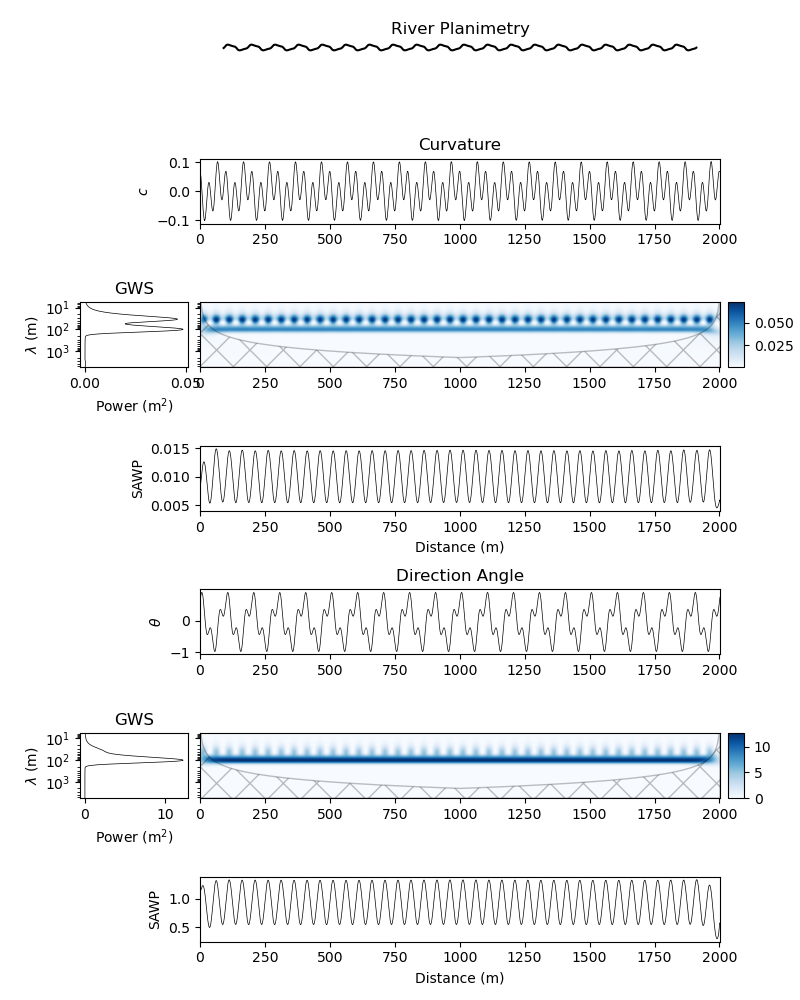

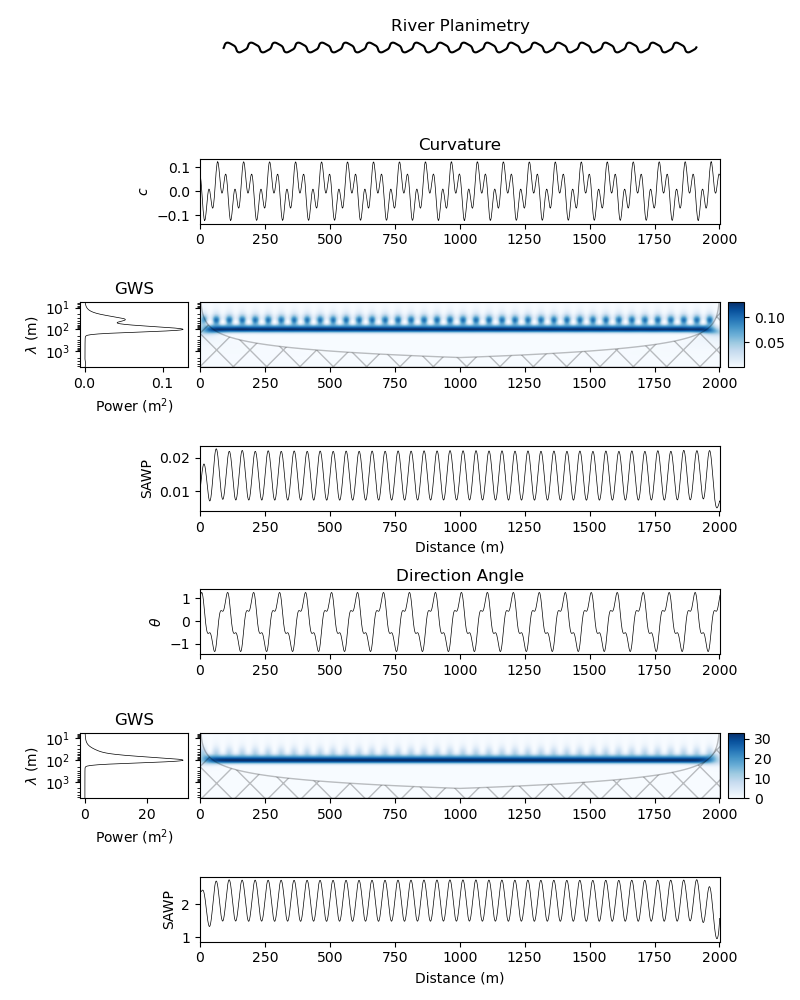

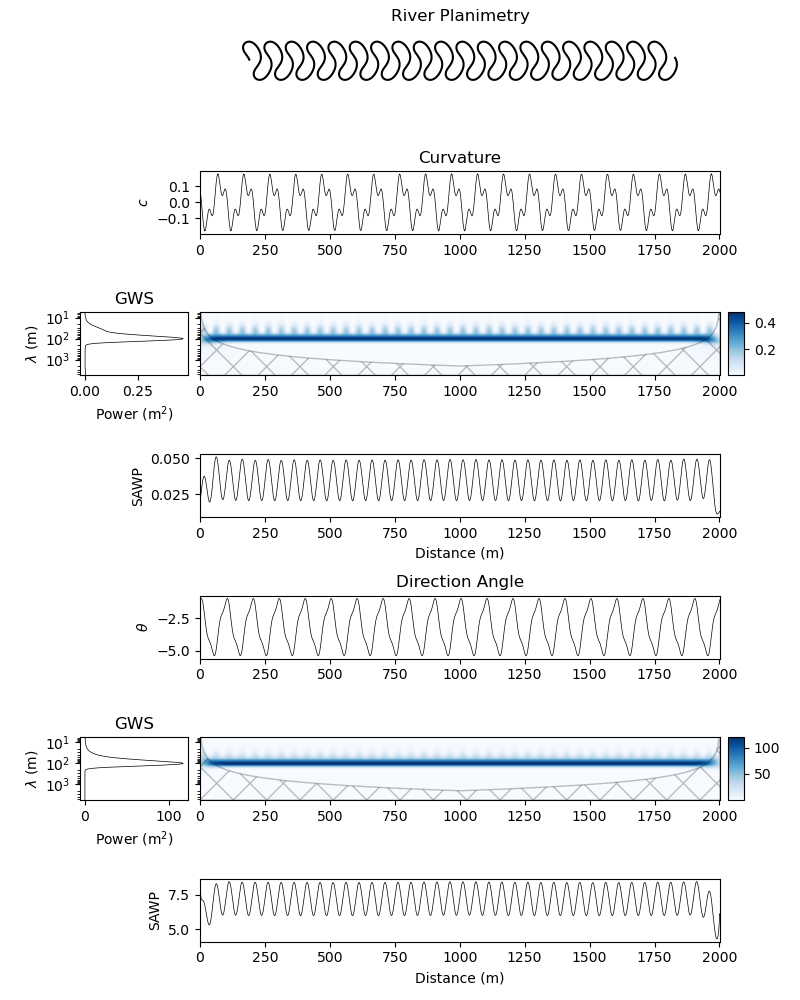

In [8]:
# Plot Condense analysis for all
plt.close('all')
for i in range(len(theta_0)):
    river = results_theta['rivers'][i]['0']
    # plot_complete_values(river, only_significant=False)
    graphs.plot_river_spectrum_compiled(river, only_significant=False)
    utl.cr_folder('kinoshita_results/')
    plt.savefig(f'kinoshita_results/kinoshita_river_{i}.png', dpi=300)


In [ ]:
# Plot Condense analysis only presenting values for the 95% significance 
plt.close('all')
for i in range(len(theta_0)):
    river = results_theta['rivers'][i]['0']
    # plot_complete_values(river, only_significant=True)
    graphs.plot_river_spectrum_compiled(river, only_significant=True)
    utl.cr_folder('kinoshita_results/')
    plt.savefig(f'kinoshita_results/kinoshita_river_{i}_sig95.png', dpi=300)


TypeError: object of type 'int' has no len()

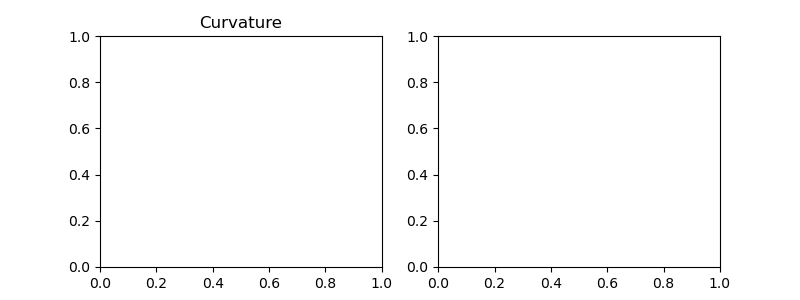

In [15]:
# --------------------
# Plot GWS information
# --------------------
plt.close('all')
f, ax = plt.subplots(1, 2, figsize=(8, 3))
i_dat = 0
ax[i_dat].set_title('Curvature')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].cwt_wavelength_c,
                   results_theta['rivers'][i]['0'].cwt_gws_c,
                   label=f'{theta_0[i]:.0f}')
ax[i_dat].set_xlabel('Wavelength (m)')
ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
# ax[i_dat].set_ylabel('Power$^2$')
ax[i_dat].set_xscale('log')
ax[i_dat].legend(title='$\\theta_0$ (deg)')

i_dat = 1
ax[i_dat].set_title('Angle')
for i in range(len(theta_0)):
    ax[i_dat].plot(results_theta['rivers'][i]['0'].cwt_wavelength_angle,
             results_theta['rivers'][i]['0'].cwt_gws_angle,
             label=f'{theta_0[i]:.0f}')
ax[i_dat].set_xlabel('Wavelength (m)')
# ax[i_dat].ylabel('Power$^2$')
ax[i_dat].axvline(lambda_value, color='k', linestyle='--')
ax[i_dat].set_xscale('log')
plt.tight_layout()
plt.savefig(f'kinoshita_results/compare_GWS_theta_angle.png', dpi=300)
plt.show()

As expected, we see that although the meanders have a variety of shapes, the wavelengths are the same. They can be seen as the strongest power signal in both, the curvature and the direction angle...

For the following example, we explore the effects of variations in the wavelength ($\lambda$) of the Kinoshita curve. We create a single meander reach where the wavelength is varying every 5 meander beds as follows $\lambda=[50, 100, 200, 500, 1000]$. The other parameters are kept constant as $\theta_0=110$, $\theta_s=0.344$, and $\theta_f=0.031$. The following code blocks below will create the compiled figures of all the river transects with and without 95% significance.

In [9]:
# Vary lambda
theta_0 = 110
# theta_s = 0.344
# theta_f = 0.031
theta_s = 0
theta_f = 0
lambda_value = [50, 100, 200, 500]
n = 5
# variables = ['rivers', 's', 'c', 'theta', 'cwt_morlet_angle',
#              'power_morlet_angle', 'wavelen_morlet_angle', 'gws_angle',
#              'sum_wave_angle', 'cwt_morlet_c', 'power_morlet_c',
#              'wavelen_morlet_c', 'gws_c', 'sum_wave_c']
variables = ['rivers']

results_lambda = {i: [] for i in variables}

for i in range(len(lambda_value)):
    result = explore_kinoshita_values(
        theta_0*np.pi/180, lambda_value[i], theta_s, theta_f, n)

    if i == 0:
        results_lambda['rivers'] = result['rivers']
    else:
        results_lambda['rivers']['0'].x = np.concatenate(
            (results_lambda['rivers']['0'].x[:-2], result['rivers']['0'].x + results_lambda['rivers']['0'].x[-1]))
        results_lambda['rivers']['0'].y = np.concatenate(
            (results_lambda['rivers']['0'].y[:-2], result['rivers']['0'].y))
        results_lambda['rivers']['0'].w_m = np.concatenate(
            (results_lambda['rivers']['0'].w_m, result['rivers']['0'].w_m))
        results_lambda['rivers']['0'].s = np.concatenate(
            (results_lambda['rivers']['0'].s, result['rivers']['0'].s + np.max(results_lambda['rivers']['0'].s)))

x = results_lambda['rivers']['0'].x
y = results_lambda['rivers']['0'].y
w_m = np.ones_like(x)

rivers_lambda = RiverDatasets(logger=logger)
rivers_lambda.add_river('0', x, y, w_m=w_m, resample_flag=True,
                        kwargs_resample={}, scale_by_width=False)

# Calculate curvature and angle
rivers_lambda['0'].calculate_curvature()
rivers_lambda['0'].get_cwt_curvature(mother='MORLET')
rivers_lambda['0'].get_cwt_angle(mother='MORLET')
x_ch = rivers_lambda['0'].x
y_ch = rivers_lambda['0'].y

2023-11-27 15:30:35,898[INFO] info: Start Logger in RiverDatasets
2023-11-27 15:30:35,903[INFO] info: Resample calculated with `River.calculate_spline()`
2023-11-27 15:30:35,933[INFO] info: Start Logger in RiverDatasets
2023-11-27 15:30:35,938[INFO] info: Resample calculated with `River.calculate_spline()`
2023-11-27 15:30:35,989[INFO] info: Start Logger in RiverDatasets
2023-11-27 15:30:35,995[INFO] info: Resample calculated with `River.calculate_spline()`
2023-11-27 15:30:36,088[INFO] info: Start Logger in RiverDatasets
2023-11-27 15:30:36,093[INFO] info: Resample calculated with `River.calculate_spline()`
2023-11-27 15:30:36,310[INFO] info: Start Logger in RiverDatasets
2023-11-27 15:30:36,319[INFO] info: Resample calculated with `River.calculate_spline()`


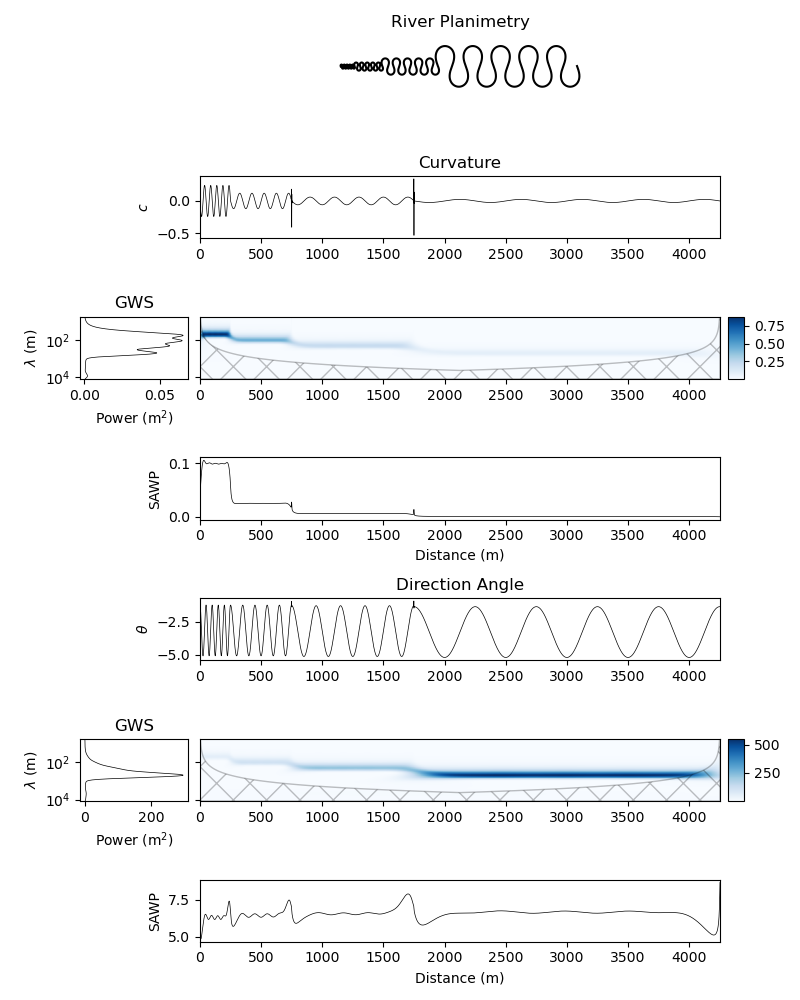

In [9]:
# Plot metrics
river = rivers_lambda['0']
graphs.plot_river_spectrum_compiled(river, only_significant=False)
utl.cr_folder('kinoshita_results/')
plt.savefig('kinoshita_results/kinoshita_lambda.png', dpi=300)


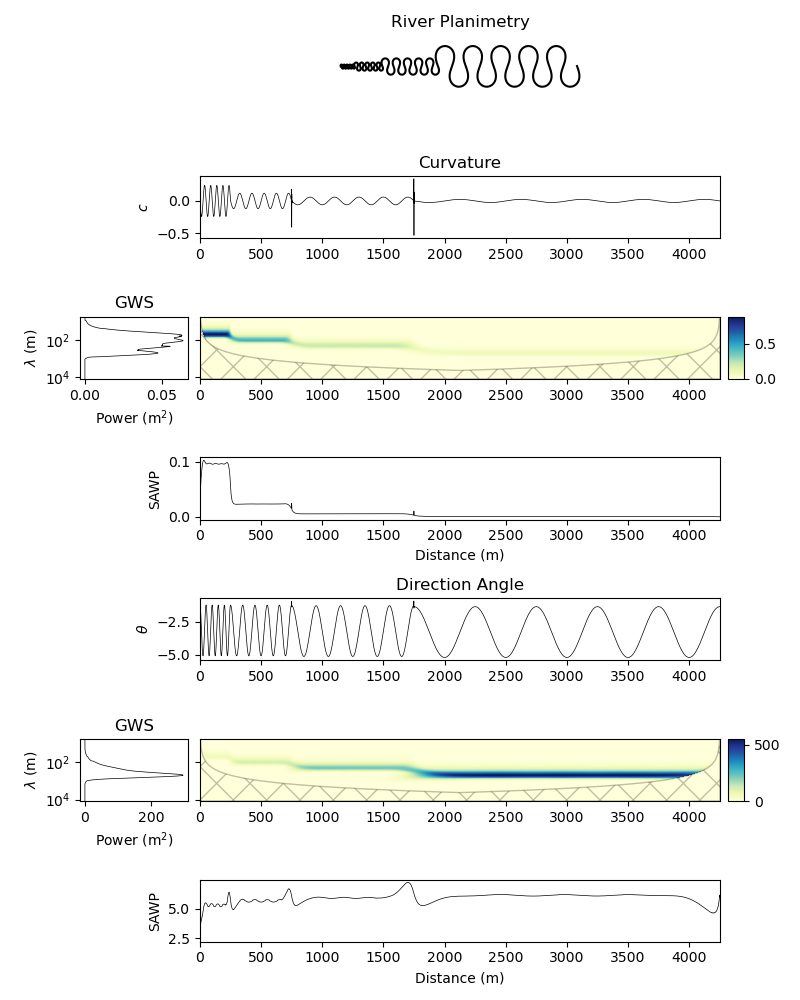

In [10]:
# Plot metrics with only significant values
river = rivers_lambda['0']
graphs.plot_river_spectrum_compiled(river, only_significant=True)
utl.cr_folder('kinoshita_results/')
plt.savefig('kinoshita_results/kinoshita_lambda_sig.png', dpi=300)


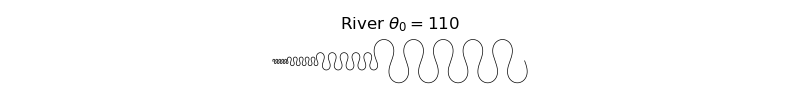

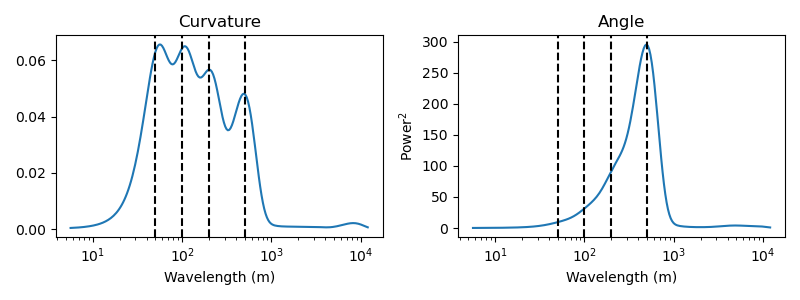

In [18]:
plt.figure(figsize=(8, 1))
plt.plot(x_ch, y_ch, '-k', linewidth=0.5)
plt.title(f'River $\\theta_0=110$')
plt.gca().set_aspect('equal', adjustable='box')
# Remove ticks
plt.xticks([])
plt.yticks([])
# Remove axis lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig(f'kinoshita_results/river_lambda.png', dpi=300)
plt.show()

# Plot GWS information
f, ax = plt.subplots(1, 2, figsize=(8, 3))
# Curavture
ax[0].set_title('Curvature')
ax[0].plot(rivers_lambda['0'].cwt_wavelength_c,
               rivers_lambda['0'].cwt_gws_c)
ax[0].set_xlabel('Wavelength (m)')
for lambda_v in lambda_value:
    ax[0].axvline(lambda_v, color='k', linestyle='--')
ax[0].set_xscale('log')
# Angle
ax[1].set_title('Angle')
ax[1].plot(rivers_lambda['0'].cwt_wavelength_angle,
           rivers_lambda['0'].cwt_gws_angle)
ax[1].set_xlabel('Wavelength (m)')
ax[1].set_ylabel('Power$^2$')
for lambda_v in lambda_value:
    ax[1].axvline(lambda_v, color='k', linestyle='--')
ax[1].set_xscale('log')
plt.tight_layout()
plt.savefig(f'kinoshita_results/compare_GWS_lambda.png', dpi=300)
plt.show()


### River Transect Meander Characterization

In the following code blocks we will show how to use the 

In [23]:
# =================================
# Create River
# =================================
# theta_0 = np.array([37.24, 60, 115])  # Degrees
# theta_s = np.array([0.344, 0.344, 0.344])
theta_0 = 115  # Degrees
theta_s = 0.344
theta_f = 0.031
lambda_value = 100
n = 20
x_k, y_k, data = RF.kinoshita_curve_zolezzi(
    theta_0=theta_0*np.pi/180, lambda_value=lambda_value, theta_s=theta_s,
    theta_f=theta_f, n=n)
w_m = np.ones_like(x_k)
# Create River Object
rivers = RiverDatasets(logger=logger)
rivers.add_river('0', x_k, y_k, w_m=w_m, resample_flag=True,
                    kwargs_resample={}, scale_by_width=False)

# Calculate curvature
rivers['0'].calculate_curvature()
# =================================
# Extract Meanders
# =================================
# --------------------
# Calculate CWT
# --------------------
rivers[f'0'].extract_cwt_tree()
# -----------------------------
# Prune by peak power
# -----------------------------
rivers[f'0'].prune_tree_by_peak_power()
# -----------------------------
# Prune by sinuosity
# -----------------------------
rivers[f'0'].prune_tree_by_sinuosity(1.05)
# -----------------------------
# Add meander to database
# -----------------------------
rivers[f'0'].add_meanders_from_tree_scales(overwrite=True, clip='downstream')
# ---------------------------
# Calculate reach sinuosity
# ---------------------------
rivers[f'0'].calculate_reach_metrics()

2023-11-27 13:34:43,054[INFO] info: Start Logger in RiverDatasets
2023-11-27 13:34:43,060[INFO] info: Resample calculated with `River.calculate_spline()`
2023-11-27 13:34:43,061[INFO] info:   Running CWT...
2023-11-27 13:34:43,127[INFO] info:   Getting the scale tree...
2023-11-27 13:34:43,890[INFO] info:   Finding peaks in CWT...
2023-11-27 13:34:43,977[INFO] info:   Detecting meanders...
2023-11-27 13:34:43,995[INFO] info:   Projecting tree in planimetry...


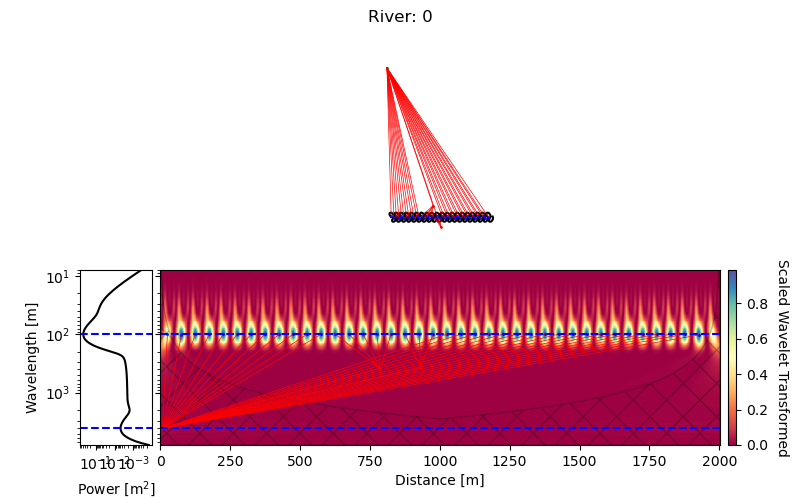

In [32]:
# Look at the meanders
rivers['0'].plot_tree_nodes(markersize=1, linewidth=0.5)

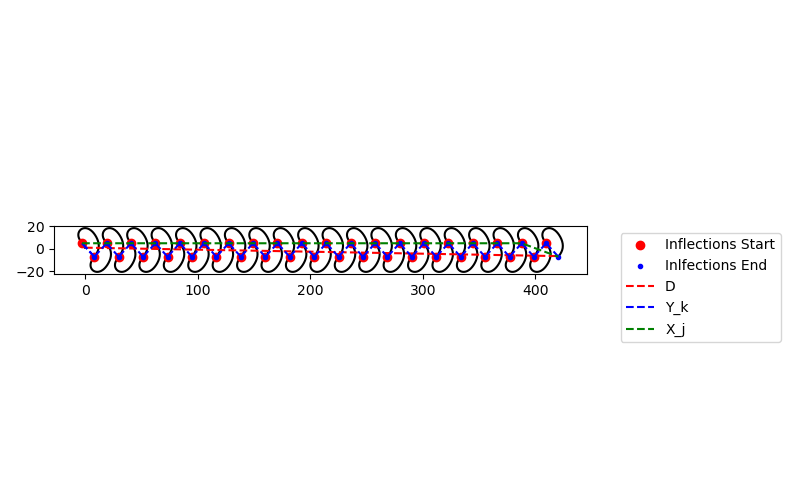

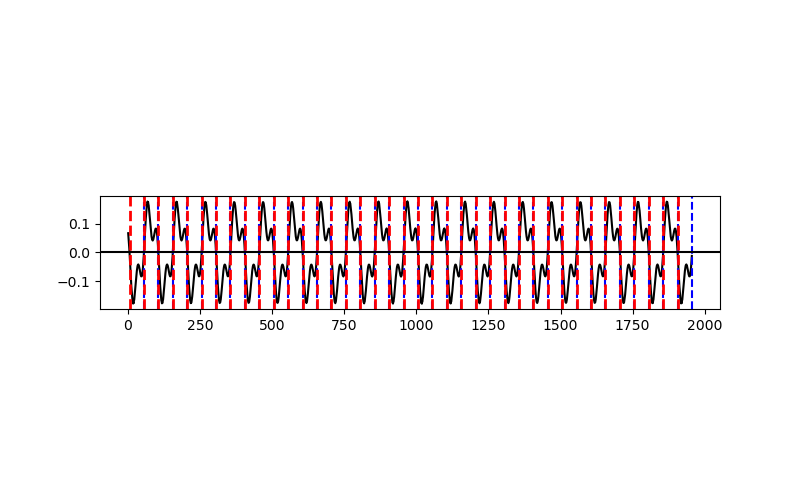

In [31]:
# Plot tree with inflection points
river_id = '0'
tree_id = 0
x_all = rivers[river_id].x
y_all = rivers[river_id].y
x = rivers[river_id].x
y = rivers[river_id].y
c = rivers[river_id].c
s_all = rivers[river_id].s
root_node = rivers[river_id].tree_scales[tree_id]
idx_st = root_node.idx_leaf_start
idx_end = root_node.idx_leaf_end
x = x[idx_st:idx_end]
y = y[idx_st:idx_end]
c = c[idx_st:idx_end]
s = s_all[idx_st:idx_end]
# database = rivers[river_id].tree_scales_database_meanders
# subdatabase = database[database['tree_id'] == tree_id]
# idx_inf_start = subdatabase['idx_planimetry_start'].values
# idx_inf_end = subdatabase['idx_planimetry_end'].values
database = rivers[river_id].database
subdatabase = database[database['tree_id'] == tree_id]
x_inf_start = subdatabase['x_start'].values
x_inf_end = subdatabase['x_end'].values
y_inf_start = subdatabase['y_start'].values
y_inf_end = subdatabase['y_end'].values
s_inf_start = subdatabase['s_start'].values
s_inf_end = subdatabase['s_end'].values

# Get lines for metrics
# Starting and ending point
d = np.array([[x[0], y[0]], [x[-1], y[-1]]])
# Hal-meander distance Y_k
# y_k = np.array([[x_all[idx_inf_start], y_all[idx_inf_start]],
#                 [x_all[idx_inf_end], y_all[idx_inf_end]]])
y_k = np.array([[x_inf_start, y_inf_start],
                [x_inf_end, y_inf_end]])
# Full meander distance X_j
n = subdatabase.shape[0]
i_start = np.arange(0, n - 1, 2)

subset_database = rivers[river_id].database[rivers[river_id].database['tree_id'] == tree_id]
x_f_m = subset_database['x_start'].values[i_start]
y_f_m = subset_database['y_start'].values[i_start]
x_f_m = np.hstack((x_f_m, subset_database['x_end'].values[-1]))
y_f_m = np.hstack((y_f_m, subset_database['y_end'].values[-1]))
x_j = np.array([x_f_m, y_f_m]).T


utl.cr_folder('kinoshita_results/closer_look/')
# plot
plt.close('all')
plt.figure(figsize=(8, 5))
plt.plot(x, y, '-k')
# plot inflection points
plt.plot(x_inf_start, y_inf_start, 'or', label='Inflections Start')
plt.plot(x_inf_end, y_inf_end, '.b', label='Inlfections End')
# plot D
plt.plot(d[:, 0], d[:, 1], '--r', label='D')
# plot y_k
plt.plot([y_k[0, 0, 0], y_k[1, 0, 0]], [y_k[0, 1, 0], y_k[1, 1, 0]], '--b', label='Y_k')
plt.plot(y_k[:, 0], y_k[:, 1], '--b')
# plot x_j
plt.plot(x_j[:, 0], x_j[:, 1], '--g', label='X_j')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(
    f'kinoshita_results/closer_look/river_{river_id}_tree_{tree_id}_inflections.png',
    dpi=300)

plt.show()

# plot curvature
plt.figure(figsize=(8, 5))
plt.plot(s, c, '-k')
# plot inflection points
for i in range(len(s_inf_start)):
    plt.axvline(s_inf_start[i], color='r', linestyle='--', label='Inflections Start',
                linewidth=2)
    plt.axvline(s_inf_end[i], color='b', linestyle='--', label='Inflections End')
plt.axhline(0, color='k', linestyle='-')
plt.gca().set_aspect(1000, adjustable='box')
plt.savefig(
    f'kinoshita_results/closer_look/c_{river_id}_tree_{tree_id}_inflections.png',
    dpi=300)
plt.show()


### Testing Examples

2023-11-27 14:53:23,159[INFO] info: Start Logger in RiverDatasets
2023-11-27 14:53:23,168[INFO] info: Resample calculated with `River.calculate_spline()`


2.007128639793479
90.0


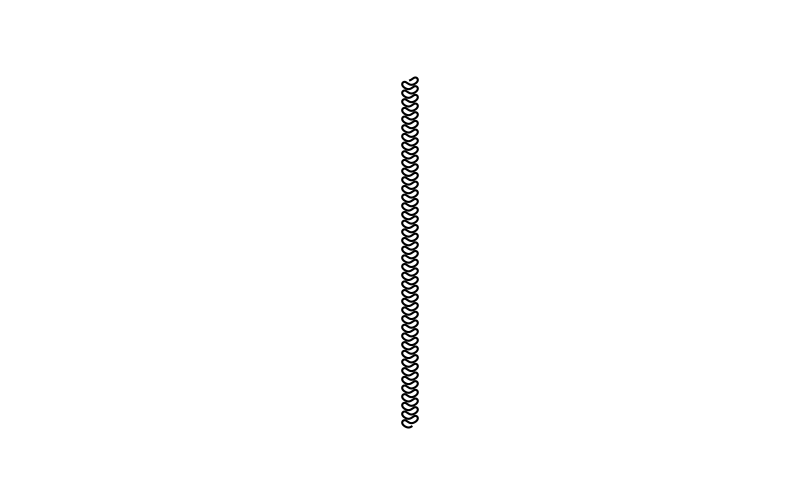

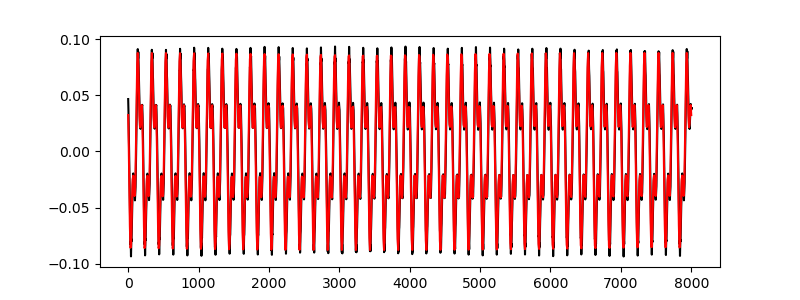

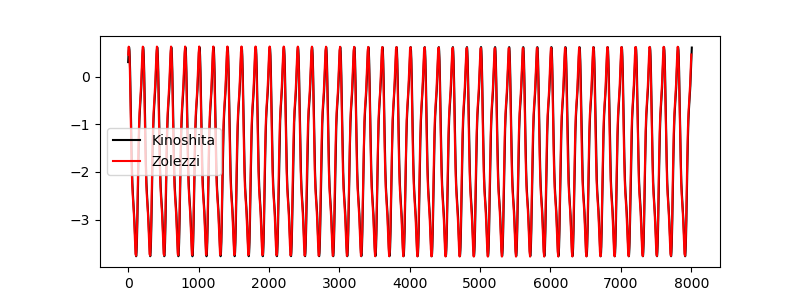

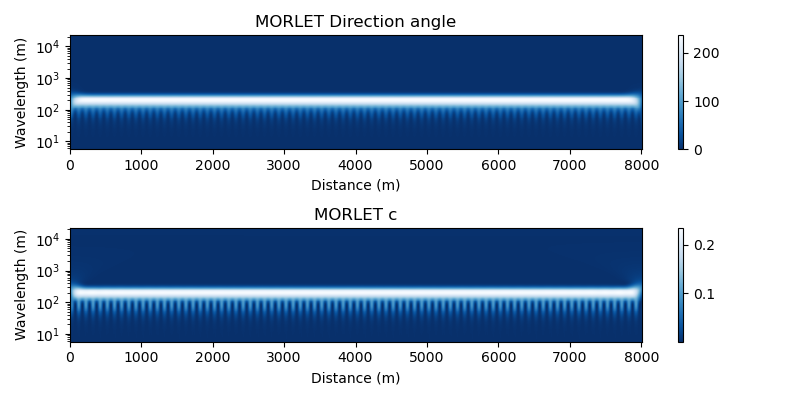

In [5]:
# --------------------
# Test calculation
# --------------------
# TODO: Erase this code block after testing
# Create Kinoshita Curve to test

theta_0 = 115 * np.pi/180
# x_k, y_k, data = RF.kinoshita_curve(theta_0=1.65, lambda_value=500, j_s=0.344, j_f=0.031, n=2)
# theta_1 = 90 * np.pi/180
# theta_1 = 0.65
print(theta_0)
x_k, y_k, data = RF.kinoshita_curve_zolezzi(
    theta_0=theta_0, lambda_value=200, theta_s=0.344, theta_f=0.031, n=40)

c_original = -data['c']
s_original = data['s']
theta_original = data['theta']*np.pi/180

w_m = np.ones_like(x_k)

# Rotate River
coords = np.vstack((x_k, y_k)).T
rot_coords, theta_2 = RF.rotate(coords, coords[0], coords[-1], 90*np.pi/180)
print(theta_2*180/np.pi)

x_k = rot_coords[:, 0]
y_k = rot_coords[:, 1]


# Create River Object
rivers_k = RiverDatasets(logger=logger)
rivers_k.add_river('0', x_k, y_k, w_m=w_m, resample_flag=True,
                   kwargs_resample={}, scale_by_width=False)

# Calculate curvature and angle
rivers_k['0'].calculate_curvature()
rivers_k['0'].get_cwt_curvature(mother='MORLET')
rivers_k['0'].get_cwt_angle(mother='MORLET')

wavelen_morlet_c = rivers_k['0'].cwt_wavelength_c
wavelen_morlet_angle = rivers_k['0'].cwt_wavelength_angle

power_morlet_c = rivers_k['0'].cwt_power_c
power_morlet_angle = rivers_k['0'].cwt_power_angle

x_k = rivers_k['0'].x
y_k = rivers_k['0'].y
s_k = rivers_k['0'].s
c = rivers_k['0'].c
theta = rivers_k['0'].angle
ds = rivers_k['0'].ds

plt.close('all')
plt.figure(figsize=(8, 5))
plt.plot(x_k, y_k, '-k')
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(s_k, c, '-k')
plt.plot(s_original, c_original, '-r')
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(s_k, theta, '-k', label='Kinoshita')
plt.plot(s_original, theta_original - theta_2, '-r', label='Zolezzi')
plt.legend()
plt.show()

f, axs = plt.subplots(2, 1, figsize=(8, 4))
im = axs[0].pcolormesh(s_k, wavelen_morlet_angle, power_morlet_angle, shading='auto', cmap='Blues_r')
axs[0].set_yscale('log')
axs[0].set_ylim([np.min(wavelen_morlet_angle), np.max(wavelen_morlet_angle)])
axs[0].set_ylabel('Wavelength (m)')
axs[0].set_xlabel('Distance (m)')
axs[0].set_title('MORLET Direction angle')
# add colorbar
f.colorbar(im, ax=axs[0])
im = axs[1].pcolormesh(s_k, wavelen_morlet_c, power_morlet_c, shading='auto', cmap='Blues_r')
axs[1].set_yscale('log')
axs[1].set_ylim([np.min(wavelen_morlet_c), np.max(wavelen_morlet_c)])
axs[1].set_ylabel('Wavelength (m)')
axs[1].set_xlabel('Distance (m)')
axs[1].set_title('MORLET c')
# add colorbar
f.colorbar(im, ax=axs[1])
plt.tight_layout()
plt.show()

In [ ]:
# gws_angle = np.mean(power_morlet, axis=1)
# gws_c = np.mean(power_morlet_c, axis=1)

sum_wave_c = np.sum(power_morlet_c, axis=0)
sum_wave_angle = np.sum(power_morlet_angle, axis=0)

gws_c = rivers_k['0'].cwt_gws_c
gws_angle = rivers_k['0'].cwt_gws_angle
sawp_c = rivers_k['0'].cwt_sawp_c
sawp_angle = rivers_k['0'].cwt_sawp_angle

plt.figure(figsize=(8, 5))
plt.plot(2*np.pi/wavelen_morlet_c, gws_angle/np.max(gws_angle), '-k', label='theta')
plt.plot(2*np.pi/wavelen_morlet_c, gws_c/np.max(gws_c), '--r', label='c')
# plt.gca().set_xscale('log')
plt.legend()
plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(s_k, sum_wave_angle/np.max(sum_wave_angle), '-k', label='theta')
# plt.plot(s_k, sawp_angle/np.max(sawp_angle), '--r', label='theta')
# plt.legend()
# plt.show()

plt.figure(figsize=(8, 5))
plt.plot(s_k, sawp_angle/np.max(sawp_angle), '-k', label='theta')
plt.plot(s_k, sawp_c/np.max(sawp_c), '--r', label='c')
plt.legend()
plt.show()


# References

Zolezzi, G., & Güneralp, I. (2016). Continuous wavelet characterization of the wavelengths and regularity of meandering rivers. Geomorphology, 252, 98–111. https://doi.org/10.1016/j.geomorph.2015.07.029
